# Permutation Tests

In [144]:
import sys
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

In [145]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"

In [146]:
dataset_model_1 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=1)
dataset_model_2 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=2)

## H0: The forecast is not prone to overestimate nor underestimate precipitation 

In [147]:
import random


def shuffle_pairs(arr: np.ndarray) -> np.ndarray:
    # Shuffle each pair individually
    for pair in arr:
        random.shuffle(pair)
    # Shuffle the entire array
    # np.random.shuffle(arr)
    return arr

merge1 = dataset_model_1.get_merge()
merge2 = dataset_model_2.get_merge()

# Bootstrap
N_BOOT = 500


boot_mean_errors = np.empty((N_BOOT, 2))
boot_mean_errors = [[], []]
for i in tqdm(range(N_BOOT)):
    data = merge1[["precipitation_forecast", "precipitation_real"]].values.copy()
    # ... shuffle it because it should not make a difference if I take the value of a perfect model or the real life data...
    data = shuffle_pairs(data)
    # ... and take the mean difference
    shuffle_error = data[:, 0] - data[:, 1]
    boot_mean_errors[0].append(shuffle_error)
    # boot_mean_errors[i, 0] = shuffle_error.mean()

    data = merge2[["precipitation_forecast", "precipitation_real"]].values.copy()
    # ... shuffle it because it should not make a difference if I take the value of a perfect model or the real life data...
    data = shuffle_pairs(data)
    # ... and take the mean difference
    shuffle_error = data[:, 0] - data[:, 1]
    boot_mean_errors[1].append(shuffle_error)
    # boot_mean_errors[i, 1] = shuffle_error.mean()


 45%|████▌     | 226/500 [00:30<00:36,  7.47it/s]


KeyboardInterrupt: 

In [ ]:
mean_error1 = merge1["precipitation_error"].mean()
mean_error2 = merge2["precipitation_error"].mean()

116642.0
Significance level = 0.06527144596286083


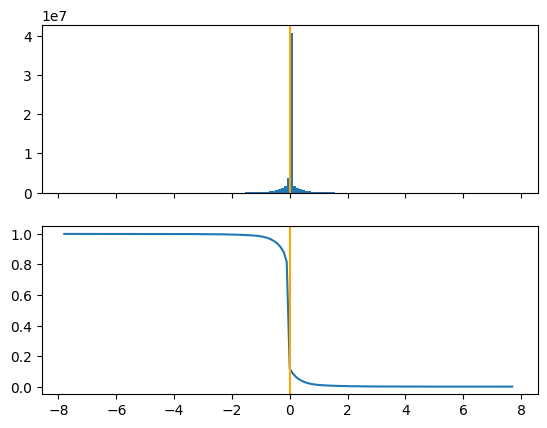

In [ ]:
# for model 1
fig, axs = plt.subplots(nrows=2, sharex=True)
concat = np.concatenate(boot_mean_errors[0])
print(len(concat) / N_BOOT)
counts, bins, _ = axs[0].hist(concat, 150)
counts = counts / counts.sum()
axs[0].axvline(mean_error1, c="orange")
cdf = np.cumsum(counts)
axs[1].plot(bins[:-1],1 - cdf)
axs[1].axvline(mean_error1, c="orange")

# bins = np.stack([b_bins, m_bins]).T
index = np.argmax((bins - mean_error1) > 0, axis=0)
# TODO: left or right bucket for p-value -> or linear interpolation
print(f"Significance level = {(1 - cdf)[index + 1]}") 

80640.0
Significance level = 0.12074739583333327


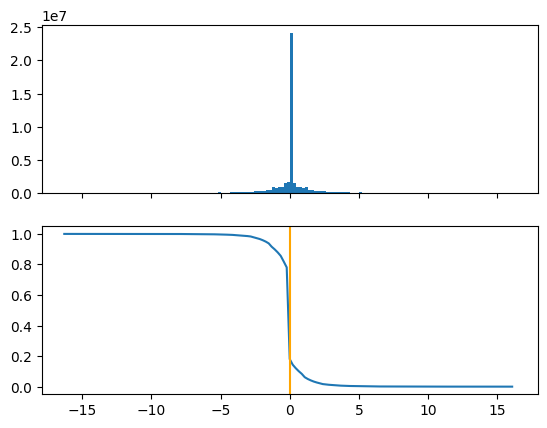

In [ ]:
# for model 2
fig, axs = plt.subplots(nrows=2, sharex=True)
concat = np.concatenate(boot_mean_errors[1])
print(len(concat) / N_BOOT)
counts, bins, _ = axs[0].hist(concat, 150)
counts = counts / counts.sum()
# axs[0].axvline(mean_error2, c="orange")
cdf = np.cumsum(counts)
axs[1].plot(bins[:-1],1 - cdf)
axs[1].axvline(mean_error2, c="orange")

# bins = np.stack([b_bins, m_bins]).T
index = np.argmax((bins - mean_error2) > 0, axis=0)
# TODO: left or right bucket for p-value -> or linear interpolation
print(f"Significance level = {(1 - cdf)[index]}") 

Conclusion: Test results are very significant. We will reject reject H0

Recall the difference plots over time steps into the future.  
Are the coefficients we found for the linear trend significant?

## H0: There is no difference between the error at t versus the error at t + h with t >= 0 and h > 0. 

In [ ]:
def poly_reg(x:np.ndarray, Y: np.ndarray, deg: int) -> np.ndarray:
    """polynomial regression

    Args:
        x (np.ndarray): ascending sorted one dimensional array 
        Y (np.ndarray): measured data. one dimensional array 
        deg (int): which degree should the polynomial have. bigger than 0

    Returns:
        np.ndarray: regression coefficients of length deg + 1
    """
    assert deg >= 0 
    num_samples = len(x)
    x = np.arange(num_samples)[:, None]
    x_aug = np.concatenate([x**i for i in range(deg + 1)], axis=1)
    regression_coef = (
        np.linalg.inv(x_aug.T @ x_aug)
        @ x_aug.T
        @ Y
    )
    return regression_coef


In [156]:
merge1 = dataset_model_1.get_merge()
merge2 = dataset_model_2.get_merge()

# absolute values
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


mean_1 = merge1.groupby("time_delta").mean().iloc[:-1]
mean_2 = merge2.groupby("time_delta").mean()

# compute real coefs
x_1 = np.arange(len(mean_1))
y_1 = mean_1["precipitation_error"].values
coefs_1 = poly_reg(x_1, y_1, deg=1)
print(coefs_1)

x_2 = np.arange(len(mean_2)) * 3
y_2 = mean_2["precipitation_error"].values / 3
coefs_2 = poly_reg(x_2, y_2, deg=1)
print(coefs_2)


N_BOOT = 1000000
coefs = np.empty((N_BOOT, 2, 2))  # num boot strap, num_forecasts, num_params
for i in tqdm(range(N_BOOT)):
    np.random.shuffle(y_1)
    coefs[i, 0] = poly_reg(x_1, y_1, deg=1)

    np.random.shuffle(y_2)
    coefs[i, 1] = poly_reg(x_2, y_2, deg=1)

[-0.00495516  0.00029572]
[ 0.04099848 -0.00098297]


  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:42<00:00, 23383.16it/s]


Significance level of slope in forecast 1 = 0.0005893739907460926 = 0.0006181091128915042
Significance level of slope in forecast 2 = 0.0007108789199544555 = 0.0010855948394025866


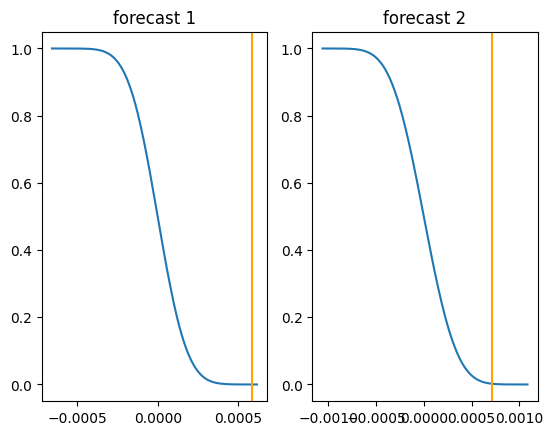

In [155]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
m_1_counts, m_1_bins = np.histogram(coefs[:, 0, 1], bins=200)
m_2_counts, m_2_bins = np.histogram(coefs[:, 1, 1], bins=200)

ax1.set_title("forecast 1")
ax1.plot(m_1_bins[1:], 1 - m_1_counts.cumsum() / m_1_counts.sum(), label="1 - cumsum")
# ax1.plot(m_1_bins[:-1], m_1_counts / m_1_counts.sum())
ax1.axvline(coefs_1[1], c="orange", label="measured slope")

ax2.set_title("forecast 2")
ax2.plot(m_2_bins[1:], 1 - m_2_counts.cumsum() / m_2_counts.sum(), label="cumsum")
# ax2.plot(m_2_bins[:-1], m_2_counts / m_2_counts.sum())
ax2.axvline(coefs_2[1], c="orange", label="measured slope")


# ax2.hist(coefs[:, 1, 1], bins=m_2_bins, density=True)

# find index
# TODO: left or right bucket for p-value -> or linear interpolation
index = np.argmax(m_1_bins - coefs_1[1])
print(
    f"Significance level of slope in forecast 1 = {coefs_1[1]} = {m_1_bins[index]}"
)
index = np.argmax(m_2_bins - coefs_2[1])
print(
    f"Significance level of slope in forecast 2 = {coefs_2[1]} = {m_2_bins[index]}"
)


In [ ]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[(merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)



In [ ]:
merge2 = dataset_model_2.get_merge() 

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[(merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 56:  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)

In [ ]:
station_errors_model_1 = error_mat_model_1.mean(axis=0)
forecast_error_model_1 = station_errors_model_1.mean(axis=0)

station_errors_model_2 = error_mat_model_2.mean(axis=0)
forecast_error_model_2 = station_errors_model_2.mean(axis=0)

In [ ]:
N_BOOT = 1000000
x = np.arange(forecast_error_model_1.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
X_1 = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T

x = np.arange(forecast_error_model_2.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
X_2 = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T


coefs = np.empty((N_BOOT, x_aug.shape[1], 2))
for i in tqdm(range(N_BOOT)):
    # shape: (num_pred_steps, num_stations)
    temp = forecast_error_model_1.copy()
    np.random.shuffle(temp)
    regression_coef = X_1 @ temp
    coefs[i, :, 0] = regression_coef

    temp = forecast_error_model_2.copy()
    np.random.shuffle(temp)
    regression_coef = X_2 @ temp
    coefs[i, :, 1] = regression_coef

100%|██████████| 1000000/1000000 [00:06<00:00, 154795.69it/s]


Significance level of mean error on b = 3.075973587815694 = 0.7887615
Significance level of mean error on m = -0.00214683342972818 = 0.7365539999999999


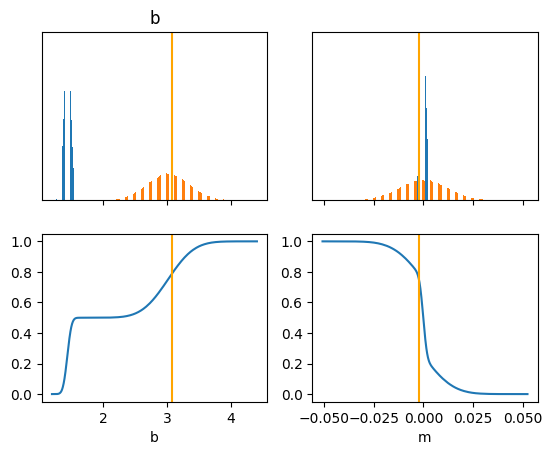

In [ ]:
fig, axs = plt.subplots(ncols=2)
b_counts, b_bins = np.histogram(coefs[:, 0], bins=1000)
m_counts, m_bins = np.histogram(coefs[:, 1], bins=1000)

axs[0, 0].hist(coefs[:, 0], bins=b_bins)
axs[0, 0].axvline(regression_coef[0], c="orange")
axs[0, 0].set_title("b")
axs[0, 0].get_yaxis().set_visible(False)
axs[0, 0].set_xticklabels([])
axs[0, 1].hist(coefs[:, 1], bins=m_bins)
axs[0, 1].axvline(regression_coef[1], c="orange")
axs[0, 1].get_yaxis().set_visible(False)
axs[0, 1].set_xticklabels([])
b_cdf = np.cumsum(b_counts) / np.sum(b_counts)
axs[1, 0].plot(b_bins[:-1], b_cdf)
axs[1, 0].axvline(regression_coef[0], c="orange")
axs[1, 0].set_xlabel("b")
m_cdf = np.cumsum(m_counts) / np.sum(m_counts)
axs[1, 1].plot(m_bins[:-1], (1 - m_cdf))
axs[1, 1].axvline(regression_coef[1], c="orange")
axs[1, 1].set_xlabel("m")

# find index 
bins = np.stack([b_bins, m_bins]).T
index = np.argmax((bins - regression_coef) > 0, axis=0)
# TODO: left or right bucket for p-value -> or linear interpolation
print(f"Significance level of mean error on b = {regression_coef[0]} = {b_cdf[index[0]]}") 
print(f"Significance level of mean error on m = {regression_coef[1]} = {(1 - m_cdf)[index[1]]}")